In [28]:
# Cell 1: Setup and Library Installation

.libPaths(c("~/BIOL616-FinalProject-Repo/Rlibs", .libPaths()))

# Install BiocManager
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager", lib = "~/BIOL616-FinalProject-Repo/Rlibs")
}

# Install data.table
install.packages("data.table", lib = "~/BIOL616-FinalProject-Repo/Rlibs")

# Install ComplexHeatmap
BiocManager::install("ComplexHeatmap", lib = "~/BIOL616-FinalProject-Repo/Rlibs")

suppressPackageStartupMessages({
    library(ggplot2)      # For Volcano plot and GSEA barplots
    library(ComplexHeatmap) # For the heatmap visualization
    library(circlize)     # Color palette for ComplexHeatmap
    library(data.table)   # For reading of the expression matrix
})

cat("All necessary visualization libraries loaded.\n")



'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.16 (BiocManager 1.30.25), R 4.2.0 (2022-04-22)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ComplexHeatmap'”


All necessary visualization libraries loaded.


In [29]:
# Cell 2: Define Paths and Load DEG Results

# Input Paths
deg_fp    <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals.csv"
expr_fp   <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/preprocessing_outputs/expr_LumA_IDC_Tumor_vs_AllNormals.tsv"
meta_fp   <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/preprocessing_outputs/metadata_LumA_IDC_Tumor_vs_AllNormals.tsv"

# Output Paths
annot_fp  <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_annotated.csv"
volcano_png <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/Volcano_LumA_IDC_Tumor_vs_AllNormals.png"
out_png_up    <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_top10_Up_in_Tumor.png"
out_png_down  <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_top10_Down_in_Tumor.png"
out_heatmap_png <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.png"
out_heatmap_pdf <- "/data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.pdf"

# Load DEG table
deg <- read.csv(deg_fp, stringsAsFactors = FALSE)
deg <- deg[!is.na(deg$pvalue) & !is.na(deg$padj), ]
cat("DEG table loaded:", nrow(deg), "genes.\n")

DEG table loaded: 20530 genes.


In [30]:
# Cell 3: Annotate and Resave DEG Table

# Thresholds
padj_cutoff    <- 0.05
log2fc_cutoff <- 1

# Annotate: -log10(padj) and regulation class
deg$negLog10Padj <- -log10(deg$padj)

deg$Regulation <- "NotSig"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange >  log2fc_cutoff] <- "Up"
deg$Regulation[deg$padj < padj_cutoff & deg$log2FoldChange < -log2fc_cutoff] <- "Down"

deg$Regulation <- factor(deg$Regulation, levels = c("Down","NotSig","Up"))

cat("DE gene counts (padj <", padj_cutoff, ", |log2FC| >", log2fc_cutoff, "):\n")
print(table(deg$Regulation))

# Save annotated DEG table
write.csv(deg, annot_fp, row.names = FALSE)
cat("Annotated DEG table written to:\n  ", annot_fp, "\n")

# Recreate ranked list 
deg$score <- sign(deg$log2FoldChange) * -log10(deg$pvalue)
deg_ranked <- deg[order(deg$score, decreasing = TRUE), ]
rnk_fp <- gsub("annotated.csv", "rnk", annot_fp) 

write.table(
    deg_ranked[, c("gene", "score")],
    rnk_fp,
    sep = "\t",
    col.names = FALSE,
    row.names = FALSE,
    quote = FALSE
)
cat("Ranked .rnk file written to:\n  ", rnk_fp, "\n")

DE gene counts (padj < 0.05 , |log2FC| > 1 ):

  Down NotSig     Up 
  2770  16339   1421 
Annotated DEG table written to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_annotated.csv 
Ranked .rnk file written to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/DEG_Results_LumA_IDC_Tumor_vs_AllNormals_rnk 


Labeling 20 most significant genes on the volcano plot.
Volcano plot saved to:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/DEG_output/Volcano_LumA_IDC_Tumor_vs_AllNormals.png 


also installing the dependencies ‘highr’, ‘xfun’, ‘yaml’






# Top 20 Genes Labeled on Volcano Plot


Table: The 20 most significant DEGs (padj < 0.05, |log2FC| > 1) sorted by adjusted p-value.

| Rank |Gene       | log2FoldChange |   padj    | Regulation |
|:----:|:----------|:--------------:|:---------:|:----------:|
|  1   |COL10A1    |      7.69      | 4.56e-167 |     Up     |
|  2   |MMP11      |      6.38      | 5.22e-149 |     Up     |
|  3   |SLC6A2     |     -3.68      | 1.59e-139 |    Down    |
|  4   |RYR3       |     -3.87      | 9.11e-130 |    Down    |
|  5   |HIF3A      |     -5.50      | 4.42e-124 |    Down    |
|  6   |LOC284578  |     -3.91      | 4.77e-122 |    Down    |
|  7   |DMD        |     -3.90      | 5.22e-120 |    Down    |
|  8   |C10orf90   |     -4.51      | 2.24e-119 |    Down    |
|  9   |LRRC3B     |     -3.77      | 4.31e-119 |    Down    |
|  10  |NDRG2      |     -2.88      | 4.20e-118 |    Down    |
|  11  |SPRY2      |     -2.87      | 7.77e-114 |    Down    |
|  12  |CA4        |     -6.55      | 1.03e-1

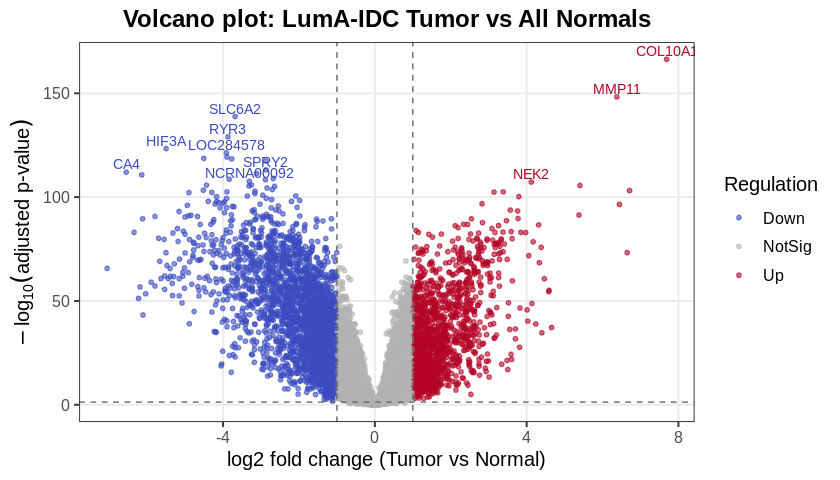

In [44]:
#Cell 4: Generate and Save Volcano Plot using ggplot2

# Choose genes to label on volcano (top 20)
deg_sig <- deg[deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]
deg_sig <- deg_sig[order(deg_sig$padj), ]

n_label <- min(20, nrow(deg_sig))
label_genes <- deg_sig[1:n_label, ]

cat("Labeling", n_label, "most significant genes on the volcano plot.\n")

# Volcano plot construction
p <- ggplot(deg, aes(x = log2FoldChange, y = negLog10Padj, color = Regulation)) +
    geom_point(alpha = 0.6, size = 1) +
    # Threshold lines
    geom_vline(xintercept = c(-log2fc_cutoff, log2fc_cutoff),
               linetype = "dashed", 
               linewidth = 0.4, 
               color = "grey40") +
    geom_hline(yintercept = -log10(padj_cutoff),
               linetype = "dashed", 
               linewidth = 0.4,  
               color = "grey40") +
    # Gene labels
    geom_text(
        data = label_genes,
        aes(label = gene),
        size = 3,
        vjust = -0.3,
        check_overlap = TRUE,
        show.legend = FALSE
    ) +
    scale_color_manual(values = c(
        "Down"  = "#3B4CC0",
        "NotSig" = "grey70",
        "Up"    = "#B40426"
    )) +
    labs(
        title = "Volcano plot: LumA-IDC Tumor vs All Normals",
        x = "log2 fold change (Tumor vs Normal)",
        y = expression(-log[10]("adjusted p-value")),
        color = "Regulation"
    ) +
    theme_bw(base_size = 12) +
    theme(
        plot.title = element_text(hjust = 0.5, face = "bold"),
        panel.grid.minor = element_blank()
    )

# Save plot
ggsave(volcano_png, p, width = 7, height = 5, dpi = 300)
cat("Volcano plot saved to:\n  ", volcano_png, "\n")

# Show volcano in output
print(p)

# Create table for top 20 significant DEGs
if (!requireNamespace("knitr", quietly = TRUE)) {
    install.packages("knitr", lib = "~/BIOL616-FinalProject-Repo/Rlibs")
}
library(knitr, lib.loc = "~/BIOL616-FinalProject-Repo/Rlibs")

# Create a data frame for printing
table_data <- data.frame(
    Rank = 1:n_label,
    Gene = label_genes$gene,
    log2FoldChange = round(label_genes$log2FoldChange, 2),
    padj = formatC(label_genes$padj, format = "e", digits = 2), # Format p-value in scientific notation
    Regulation = label_genes$Regulation,
    stringsAsFactors = FALSE
)

# Print the table using kable() for clean Markdown formatting
cat("\n\n")
cat("# Top", n_label, "Genes Labeled on Volcano Plot\n")
print(
    kable(
        table_data, 
        align = c("c", "l", "c", "c", "c"),
        caption = paste("The", n_label, "most significant DEGs (padj < 0.05, |log2FC| > 1) sorted by adjusted p-value.")
    )
)

In [32]:
# Cell 5: Merge GSEA Output Files

# KEGG Legacy Paths
kegg_legacy_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Legacy/gsea_report_for_na_pos_1764644573051.tsv"
kegg_legacy_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Legacy/gsea_report_for_na_neg_1764644573051.tsv"

# KEGG Medicus Paths
kegg_medicus_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Medicus/gsea_report_for_na_pos_1764645583710.tsv"
kegg_medicus_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/KEGG-Medicus/gsea_report_for_na_neg_1764645583710.tsv"

# Hallmark Paths
hallmark_pos_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/Hallmark-All/gsea_report_for_na_pos_1763154663293.tsv"
hallmark_neg_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/Hallmark-All/gsea_report_for_na_neg_1763154663293.tsv"

# Helper Function to Load and Annotate
load_gsea_reports <- function(pos_fp, neg_fp, db_name) {
    # Load Positive Enrichment (Upreg in Tumor)
    pos <- read.delim(pos_fp, stringsAsFactors = FALSE)
    pos$direction <- "Up_in_Tumor"
    pos$Database <- db_name

    # Load Negative Enrichment (Downreg in Tumor)
    neg <- read.delim(neg_fp, stringsAsFactors = FALSE)
    neg$direction <- "Down_in_Tumor"
    neg$Database <- db_name

    return(rbind(pos, neg))
}

# Load and Combine All Three Databases
gsea_legacy <- load_gsea_reports(kegg_legacy_pos_fp, kegg_legacy_neg_fp, "KEGG_Legacy")
gsea_medicus <- load_gsea_reports(kegg_medicus_pos_fp, kegg_medicus_neg_fp, "KEGG_Medicus")
gsea_hallmark <- load_gsea_reports(hallmark_pos_fp, hallmark_neg_fp, "Hallmark")

# Combine all results into one master data frame
gsea_all <- rbind(gsea_legacy, gsea_medicus, gsea_hallmark)

# Sort by NES descending (Normalized Enrichment Score)
gsea_all <- gsea_all[order(gsea_all$NES, decreasing = TRUE), ]

# Save combined summary
out_fp <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv"
write.csv(gsea_all, out_fp, row.names = FALSE)
cat("Wrote combined GSEA summary to:\n  ", out_fp, "\n")

head(gsea_all[, c("NAME", "Database", "NES", "FDR.q.val", "direction")], 15)

Wrote combined GSEA summary to:
   ~/BIOL616-FinalProject-Repo/datasets/GSEA_output/GSEA_ALL_summary_LumA_IDC_Tumor_vs_AllNormals.csv 


,NAME,Database,NES,FDR.q.val,direction
,<chr>,<chr>,<dbl>,<dbl>,<chr>
177,KEGG_MEDICUS_REFERENCE_ORIGIN_UNWINDING_AND_ELONGATION,KEGG_Medicus,2.158563,0.0000000000,Up_in_Tumor
1,KEGG_PROTEASOME,KEGG_Legacy,2.139744,0.0000000000,Up_in_Tumor
2,KEGG_DNA_REPLICATION,KEGG_Legacy,2.137784,0.0000000000,Up_in_Tumor
3,KEGG_BASE_EXCISION_REPAIR,KEGG_Legacy,2.065026,0.0000000000,Up_in_Tumor
4,KEGG_CELL_CYCLE,KEGG_Legacy,2.060763,0.0000000000,Up_in_Tumor
178,KEGG_MEDICUS_VARIANT_MUTATION_CAUSED_ABERRANT_HTT_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_Medicus,2.055046,0.0005537635,Up_in_Tumor
179,KEGG_MEDICUS_REFERENCE_PRE_IC_FORMATION,KEGG_Medicus,2.043467,0.0007930439,Up_in_Tumor
180,KEGG_MEDICUS_VARIANT_MUTATION_CAUSED_ABERRANT_ABETA_TO_26S_PROTEASOME_MEDIATED_PROTEIN_DEGRADATION,KEGG_Medicus,2.021111,0.0005947830,Up_in_Tumor
181,KEGG_MEDICUS_REFERENCE_HOMOLOGOUS_RECOMBINATION,KEGG_Medicus,2.013761,0.0004758264,Up_in_Tumor


Saved plots for KEGG_Medicus. Pathways shown:19.


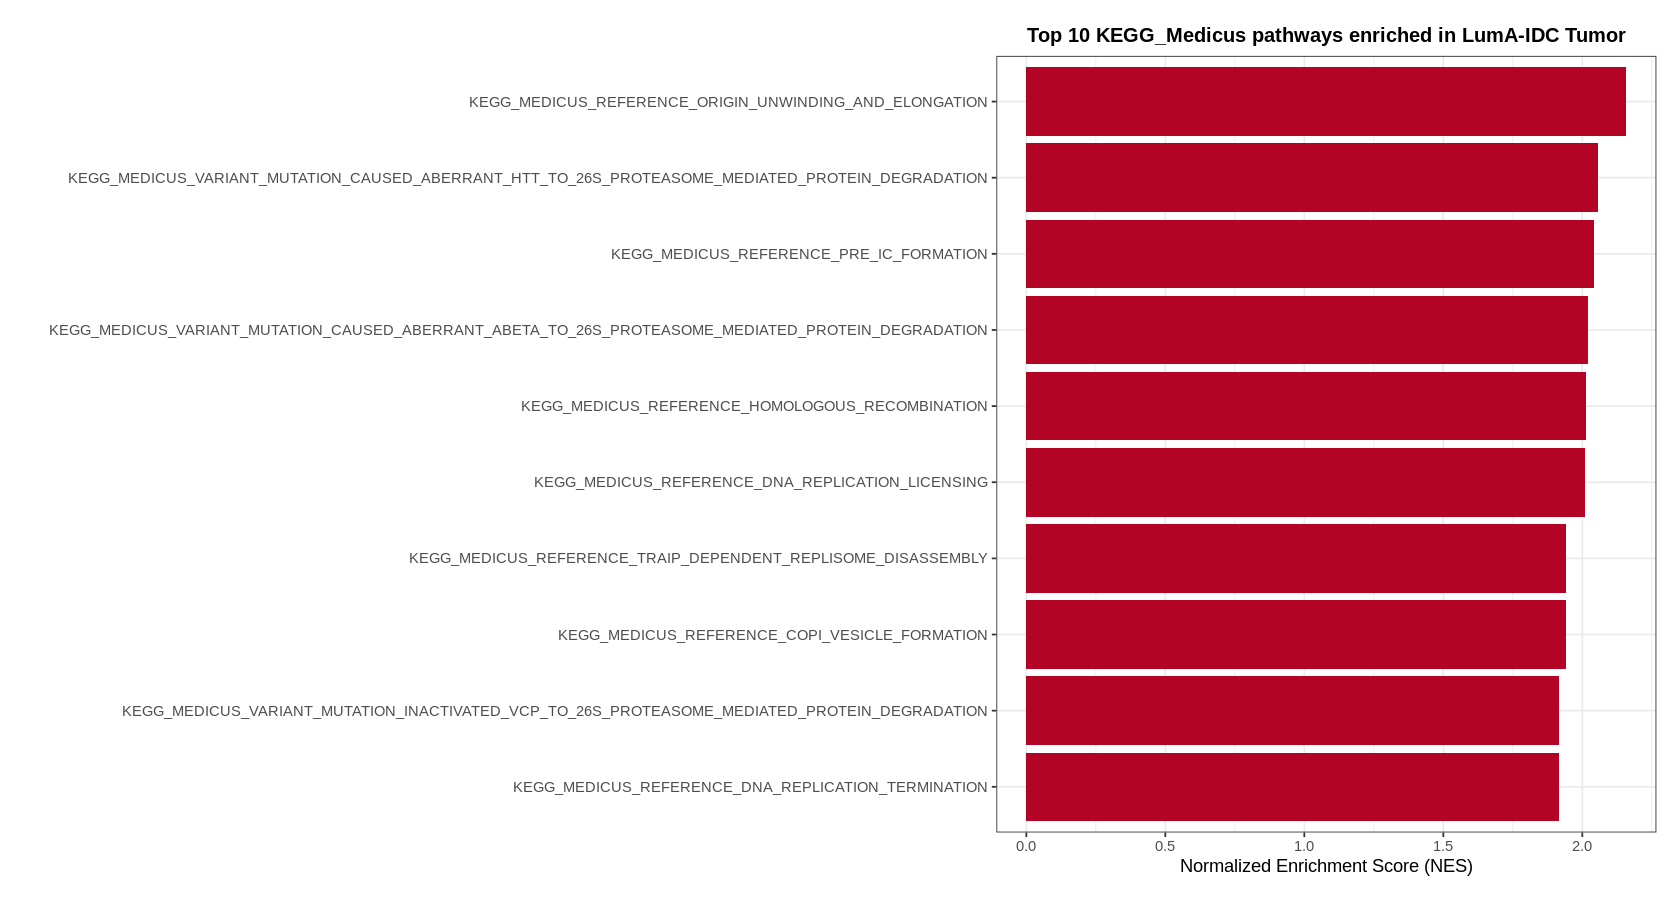

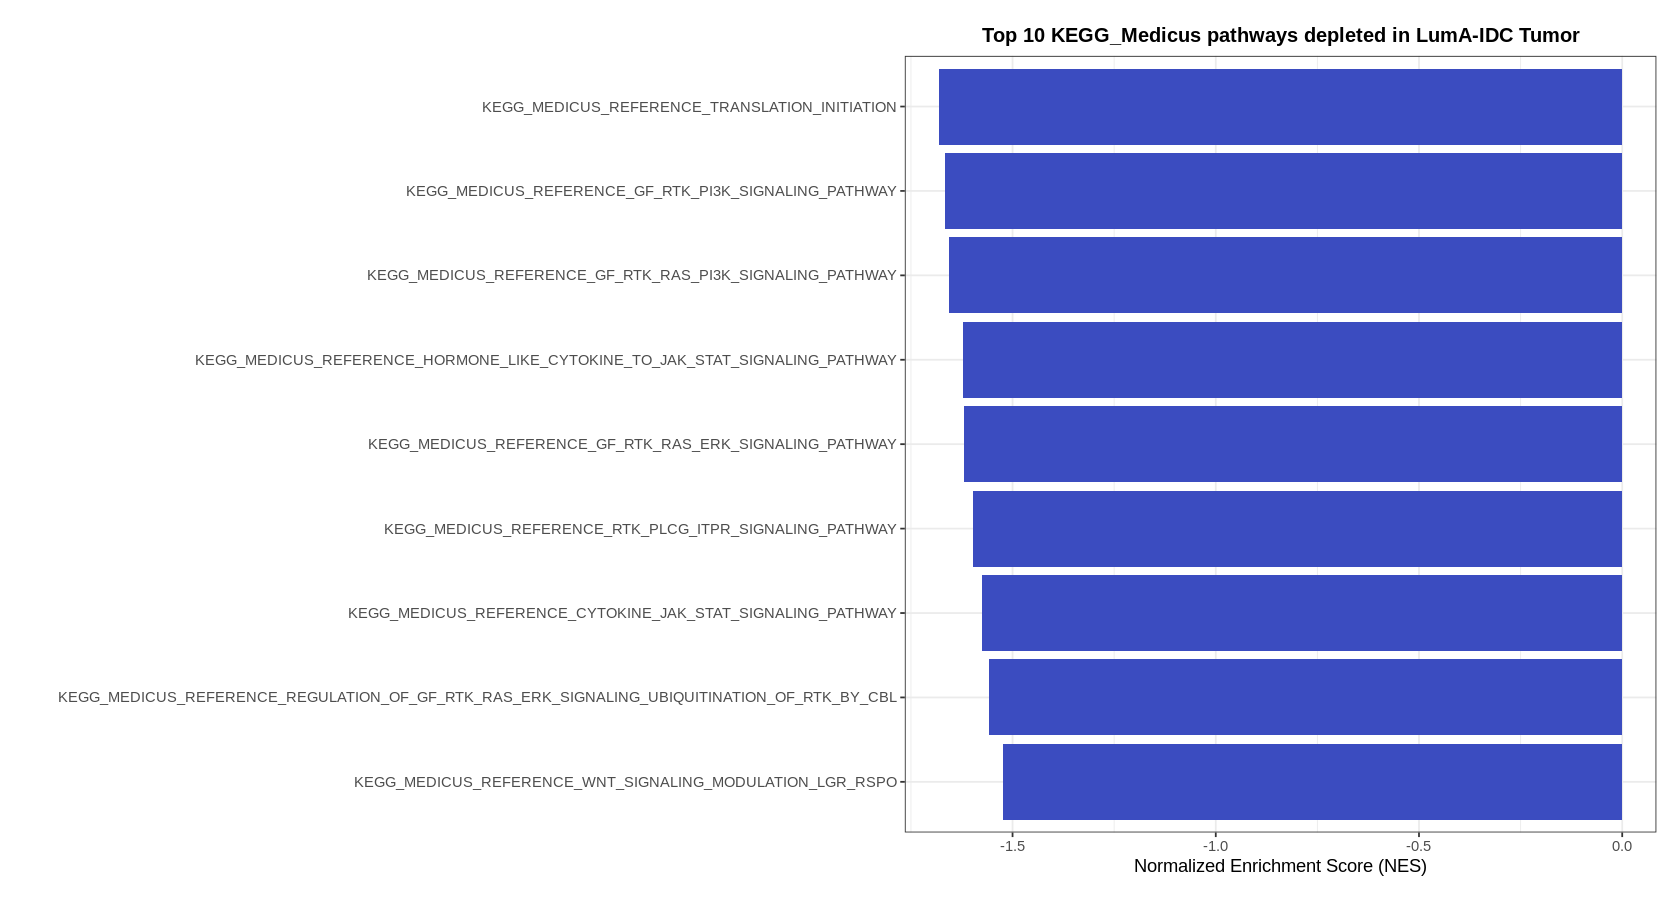

Saved plots for KEGG_Legacy. Pathways shown:20.


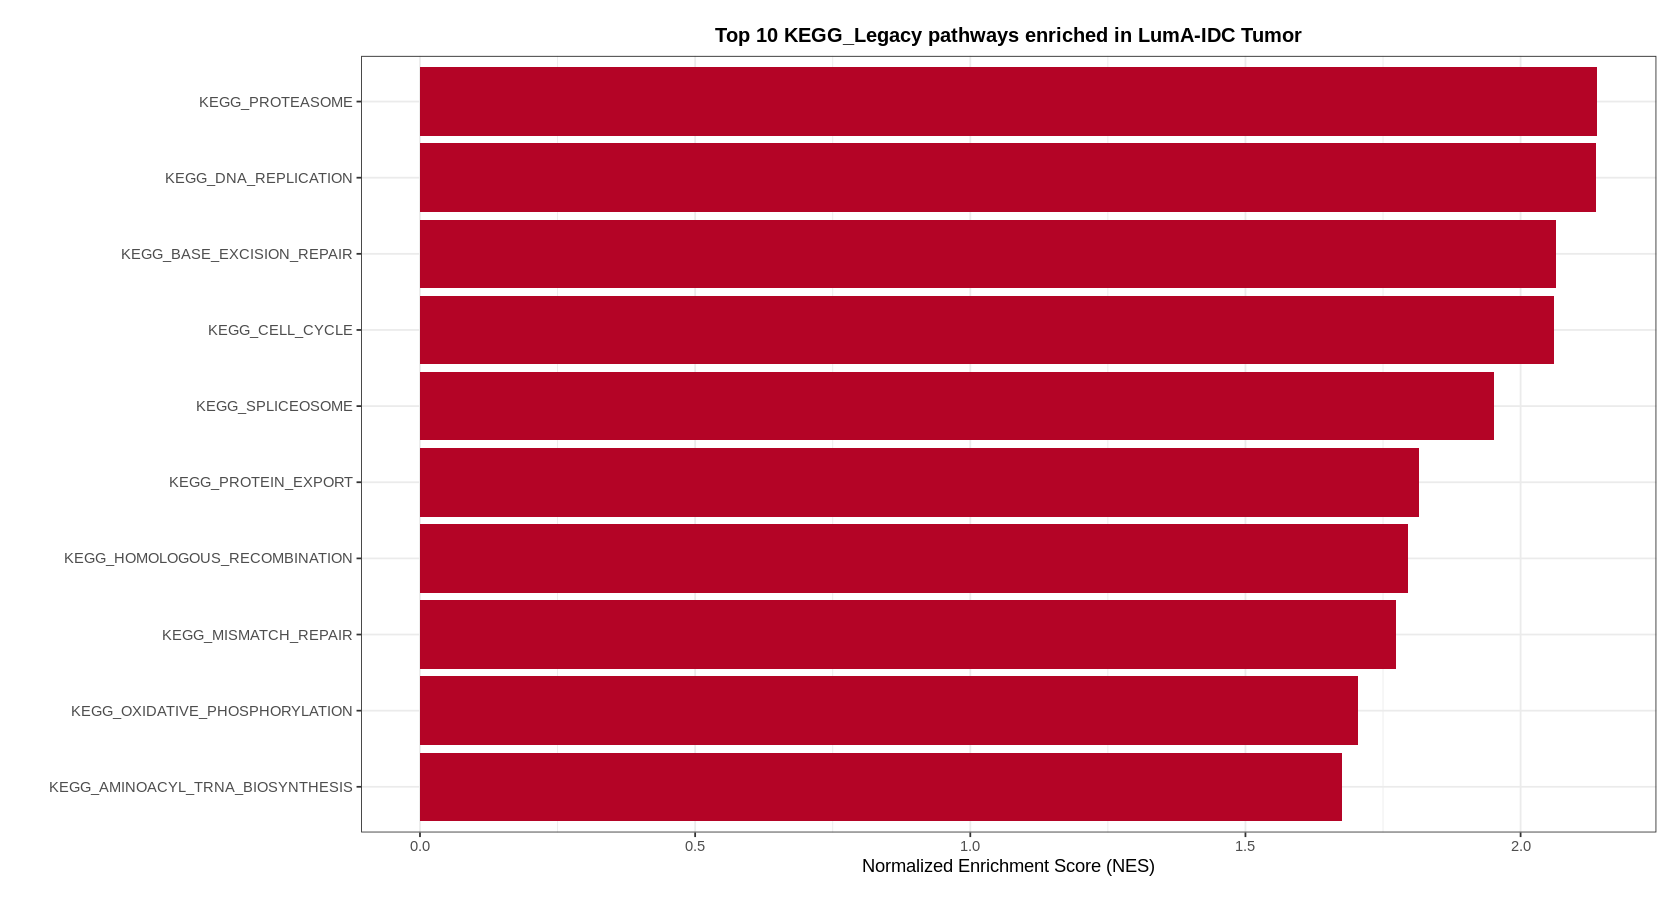

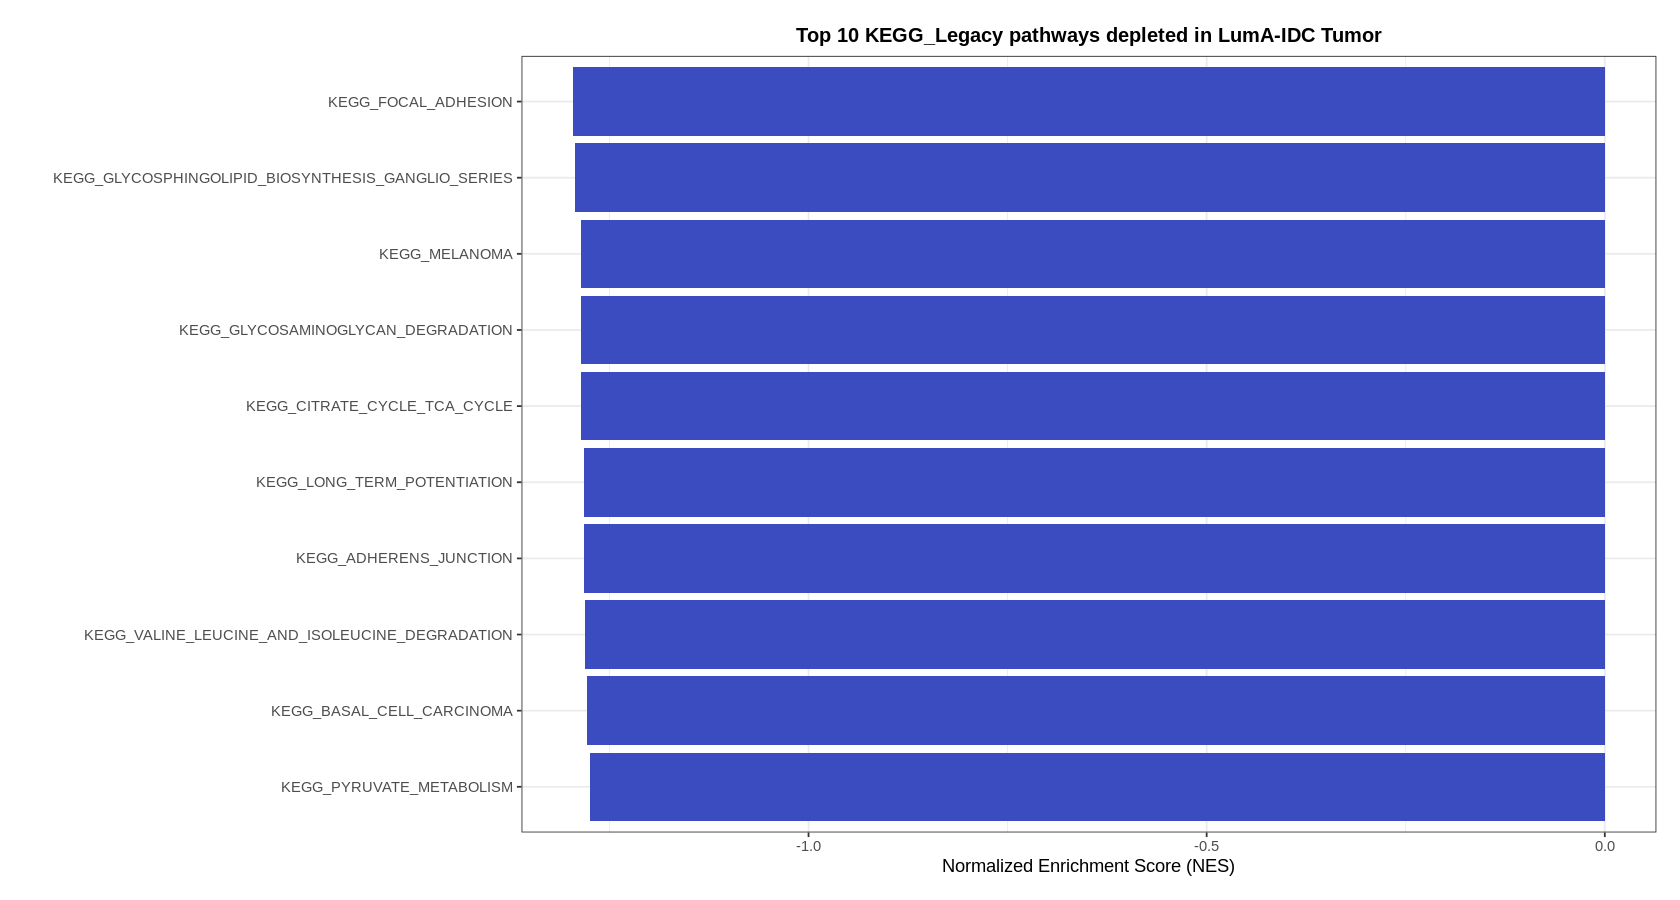

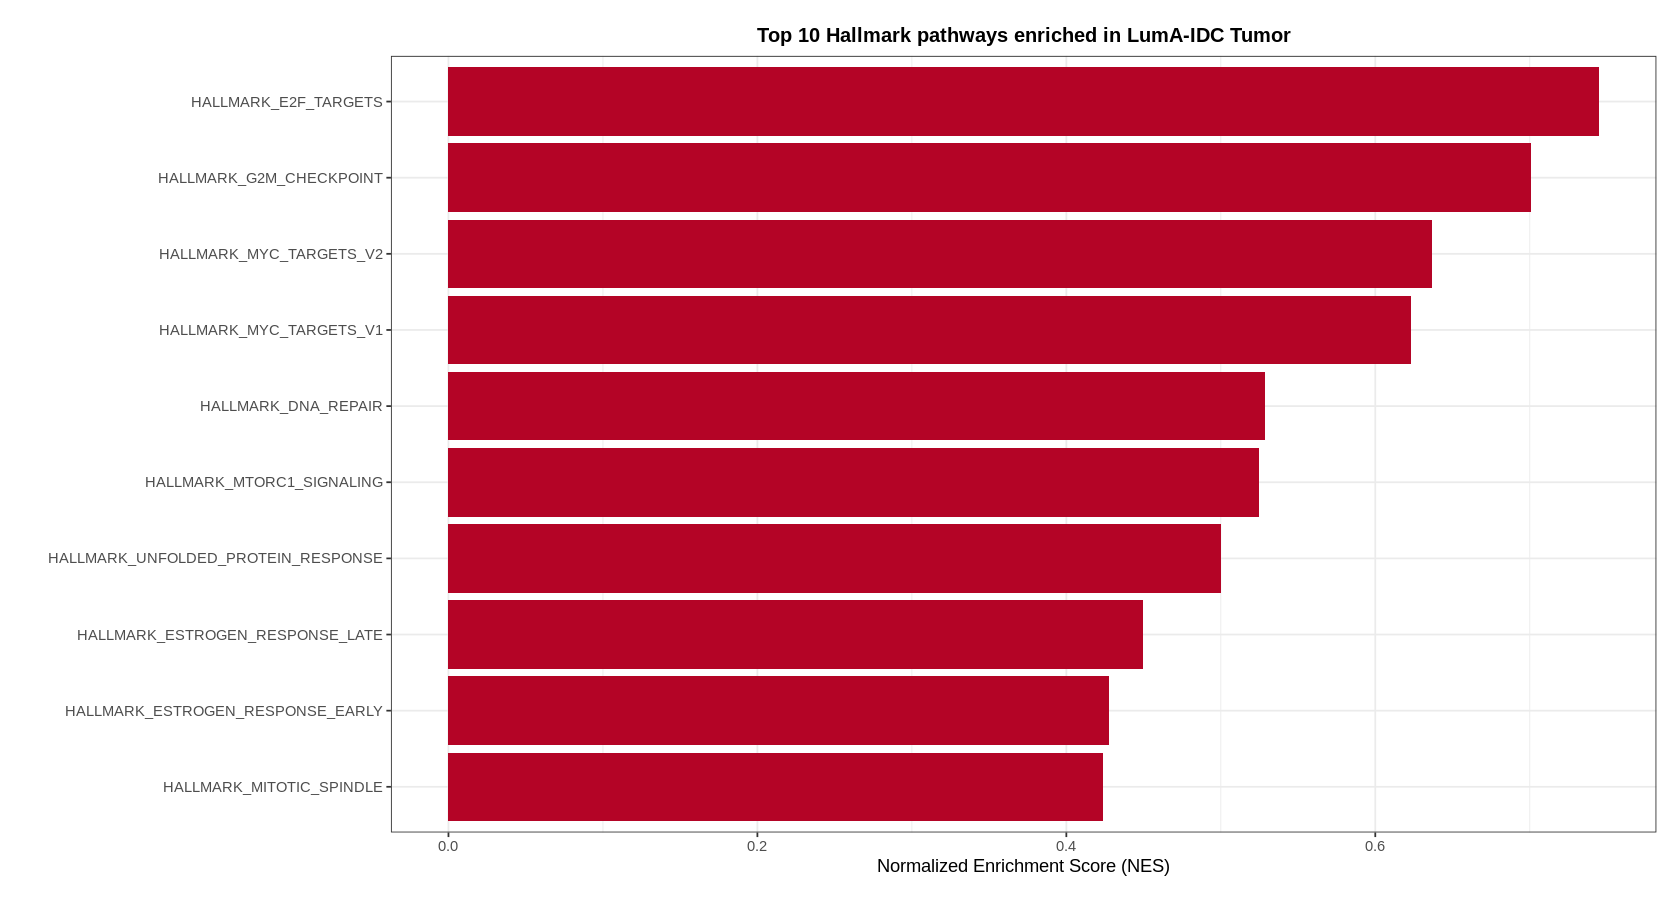

Saved plots for Hallmark. Pathways shown:20.

All GSEA barplots saved and displayed.


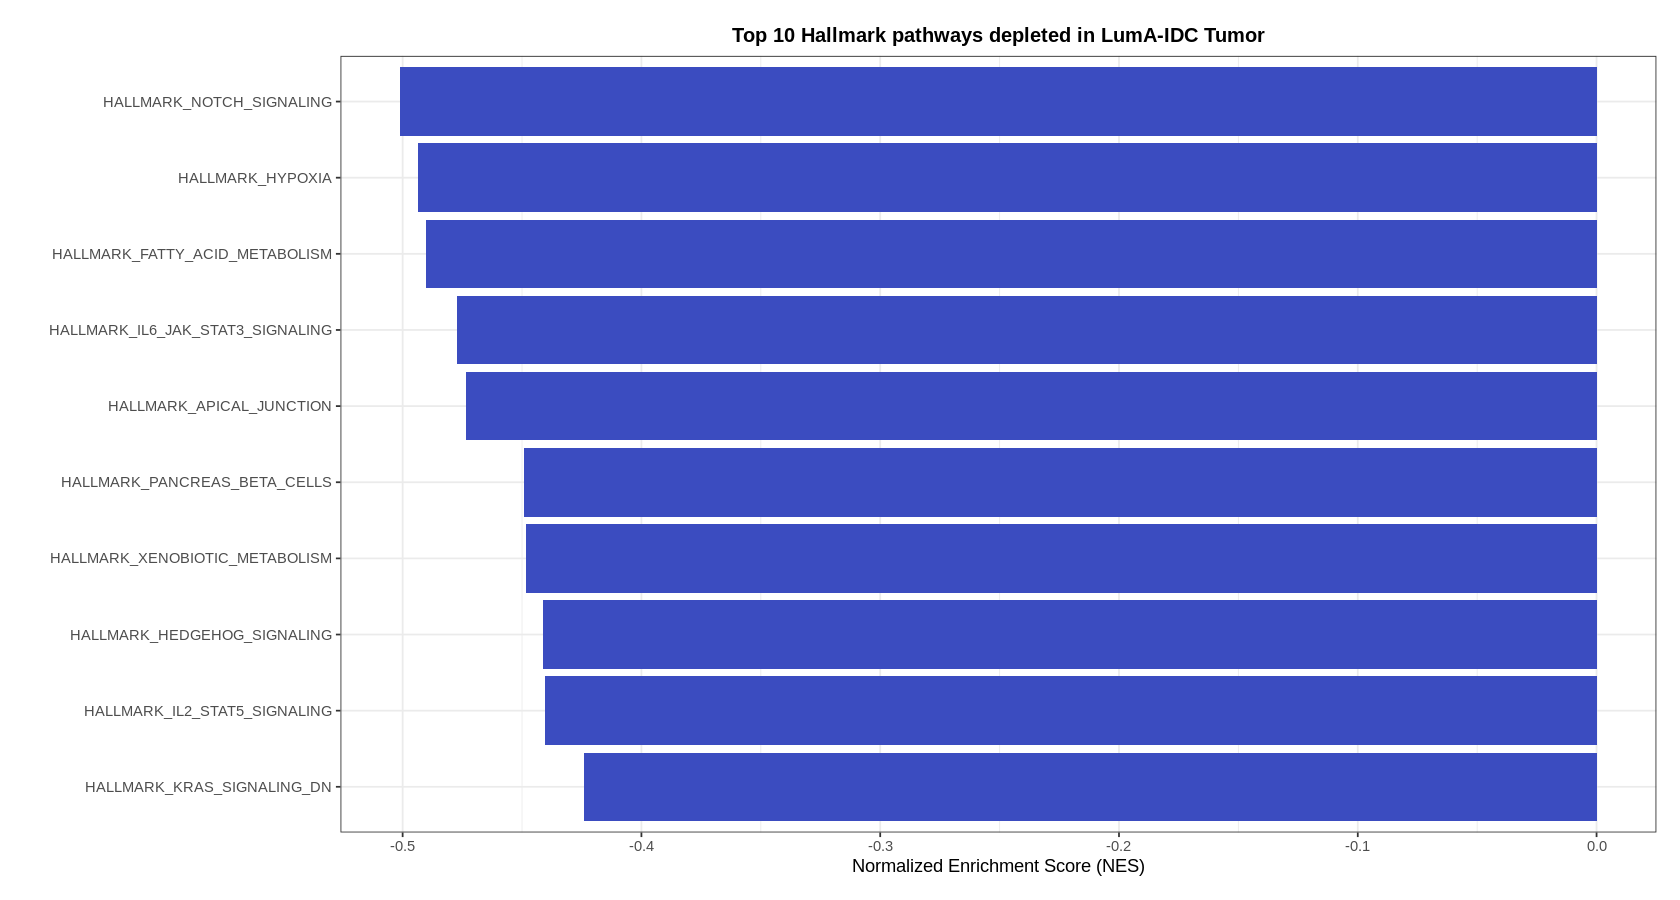

In [42]:
# Cell 6: Generate GSEA Barplots for all 3 GSEA Runs (KEGG-Medicus, KEGG-Legacy, Hallmark-All)

# Define the list of databases to iterate over (KEGG-Medicus, KEGG-Legacy, Hallmark-All)
databases_to_plot <- unique(gsea_all$Database)

# Define output directory 
out_dir <- "~/BIOL616-FinalProject-Repo/datasets/GSEA_output/" 

# Define plot dimensions for saving
PLOT_WIDTH <- 11
PLOT_HEIGHT <- 8.0 

# Loop through each database to create plots
for (db_name in databases_to_plot) {
    
    # Filter for the current database and significant pathways
    gsea_db_sig <- gsea_all[gsea_all$Database == db_name & gsea_all$FDR.q.val < 0.25, ]
    
    # Filter for up vs down
    gsea_up   <- gsea_db_sig[gsea_db_sig$direction == "Up_in_Tumor", ]
    gsea_down <- gsea_db_sig[gsea_db_sig$direction == "Down_in_Tumor", ]
    
    top_up   <- gsea_up[1:min(10, nrow(gsea_up)), ]
    top_down <- gsea_down[1:min(10, nrow(gsea_down)), ]
    
    # Ensure pathway names are ordered for plotting
    top_up$NAME    <- factor(top_up$NAME,    levels = rev(top_up$NAME))
    top_down$NAME <- factor(top_down$NAME, levels = top_down$NAME)
    
    # Upregulated pathway plot
    p_up <- ggplot(top_up, aes(x = NAME, y = NES)) +
        geom_col(fill="#B40426") +
        coord_flip() +
        labs(
            title = paste0("Top 10 ", db_name, " pathways enriched in LumA-IDC Tumor"),
            x = "",
            y = "Normalized Enrichment Score (NES)"
        ) +
        theme_bw(base_size = 11) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold", size = 12), 
            plot.margin = unit(c(0.6, 0.5, 0.5, 0.5), "cm") 
        )
    
    # Downregulated pathway plot
    p_down <- ggplot(top_down, aes(x = NAME, y = NES)) +
        geom_col(fill="#3B4CC0") +
        coord_flip() +
        labs(
            title = paste0("Top 10 ", db_name, " pathways depleted in LumA-IDC Tumor"),
            x = "",
            y = "Normalized Enrichment Score (NES)"
        ) +
        theme_bw(base_size = 11) +
        theme(
            plot.title = element_text(hjust = 0.5, face = "bold", size = 12),
            plot.margin = unit(c(0.6, 0.5, 0.5, 0.5), "cm") 
        )
    
    # Save Plots 
    out_png_up    <- file.path(out_dir, paste0("GSEA_top10_", db_name, "_Up_in_Tumor.png"))
    out_png_down <- file.path(out_dir, paste0("GSEA_top10_", db_name, "_Down_in_Tumor.png"))
    
    
    ggsave(out_png_up, p_up, width = PLOT_WIDTH, height = PLOT_HEIGHT, dpi = 300)
    ggsave(out_png_down, p_down, width = PLOT_WIDTH, height = PLOT_HEIGHT, dpi = 300)

    options(repr.plot.width = 14, repr.plot.height = 7.5) 
    print(p_up)
    print(p_down)
    
    
    cat(paste0("Saved plots for ", db_name, ". Pathways shown:", nrow(top_up) + nrow(top_down), ".\n"))
}

cat("\nAll GSEA barplots saved and displayed.\n")
options(repr.plot.width = 7, repr.plot.height = 4) 

In [34]:
# Cell 7: Heatmap: Prepare Data and Annotations

# Save significant DEGs
deg_sig <- deg[deg$padj < padj_cutoff & abs(deg$log2FoldChange) > log2fc_cutoff, ]

# Top 25 up and top 25 down by padj
deg_up    <- deg_sig[deg_sig$log2FoldChange > 0, ]
deg_down <- deg_sig[deg_sig$log2FoldChange < 0, ]

deg_up    <- deg_up[order(deg_up$padj), ][1:min(25, nrow(deg_up)), ]
deg_down <- deg_down[order(deg_down$padj), ][1:min(25, nrow(deg_down)), ]

genes_top  <- unique(c(deg_up$gene, deg_down$gene))
genes_top <- genes_top[genes_top %in% rownames(expr)] # Ensure genes are in the expression matrix

cat("Heatmap includes", length(genes_top), "total DEGs (up and down).\n")

# Load expression matrix (using data.table::fread) 
expr_dt <- data.table::fread(expr_fp, check.names = FALSE)
expr <- as.data.frame(expr_dt)
rownames(expr) <- expr[[1]]
expr <- expr[,-1]

# Load metadata
meta <- read.csv(meta_fp, stringsAsFactors = FALSE, check.names = FALSE)

# --- Define ID Normalization Function 
normalize_ids <- function(x) {
    x <- as.character(x)
    x <- gsub("\\.", "-", x)
    x <- substr(x, 1, 15) # Standard TCGA barcode length
    return(x)
}

# Apply Normalization and Alignment
colnames(expr) <- normalize_ids(colnames(expr))
meta$Sample_norm <- normalize_ids(meta$Sample)
rownames(meta) <- meta$Sample_norm

common_samples <- intersect(colnames(expr), rownames(meta))

if (length(common_samples) < 2) {
    stop("Fewer than 2 overlapping samples after ID normalization. Cannot proceed with heatmap.")
}

expr_sub <- expr[genes_top, common_samples, drop = FALSE]
meta_sub <- meta[common_samples, , drop = FALSE]

# Scale rows (Z-score)
expr_scaled <- t(scale(t(expr_sub)))

Heatmap includes 50 total DEGs (up and down).


In [35]:
#Cell 8: Generate and Save Heatmap

# Define Annotations
sample_group <- meta_sub$Group
names(sample_group) <- rownames(meta_sub)

ha_col <- HeatmapAnnotation(
    Group = sample_group,
    col = list(Group = c("Tumor" = "#B40426", "Normal" = "#3B4CC0"))
)

row_reg <- ifelse(rownames(expr_scaled) %in% deg_up$gene, "Up_in_Tumor", "Down_in_Tumor")

ha_row <- rowAnnotation(
    Regulation = row_reg,
    col = list(Regulation = c("Up_in_Tumor" = "#B40426", "Down_in_Tumor" = "#3B4CC0"))
)

# Heatmap Construction
h <- Heatmap(
    expr_scaled,
    name = "Z-score",
    top_annotation = ha_col,
    left_annotation = ha_row,
    show_row_names = TRUE,
    show_column_names = FALSE,
    cluster_rows = TRUE,
    cluster_columns = TRUE,
    row_names_gp = gpar(fontsize = 6),
    column_title = "Top DEGs (LumA-IDC Tumor vs All Normals)",
    heatmap_legend_param = list(title = "Expression")
)

# Save Plots

dir.create(dirname(out_heatmap_png), recursive = TRUE, showWarnings = FALSE)

# Save as PNG
png(out_heatmap_png, width = 2000, height = 1500, res = 200)
print(h)       
dev.off()

# Save as PDF
pdf(out_heatmap_pdf, width = 12, height = 10)
print(h)
dev.off()

cat("Saved heatmap:\n  ", out_heatmap_png, "\n  ", out_heatmap_pdf, "\n")

pdf 
  2

pdf 
  2

Saved heatmap:
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.png 
   /data/Bio2025/Thomas/BIOL616-FinalProject-Repo/datasets/GSEA_output/Top50_DEGs_Heatmap.pdf 
